In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

sns.reset_defaults()
sns.set_theme(rc={'figure.dpi': 72, 'savefig.dpi': 300,
              'figure.autolayout': True})
sns.set_style('ticks')
sns.set_context('paper')

np.set_printoptions(precision=4)


In [2]:
# Part a

# Load the dataset
df = pd.read_csv('data/P2/HCV.csv')
X = df.iloc[:, 2:]
y = df.iloc[:, 1]

# Preprocess
# Convert categorical to numerical
y = y.replace(['0=Blood Donor', '0s=suspect Blood Donor'], 0)
y = y.replace('1=Hepatitis', 1)
y = y.replace('2=Fibrosis', 2)
y = y.replace('3=Cirrhosis', 3)
X['Sex'] = X['Sex'].replace('f', 0)
X['Sex'] = X['Sex'].replace('m', 1)

# Normalize using standard scaler
X = X.apply(lambda x: (x - np.mean(x)) / np.std(x))
X = X.fillna(0)
X, y = X.values, y.values


In [3]:
# Part b

def Euclidean(x, X):
    """Return the Euclidean distances between
    an instance x and the dataset X."""
    return np.sqrt(np.sum((x - X)**2, axis=1))


def CityBlock(x, X):
    """Return the Manhattan distances between
    an instance x and the dataset X."""
    return np.sum(np.abs(x - X), axis=1)


def KMeans(X, ClusterCount=2, Iteration=30, ConvergenceRatio=0.01, DistanceMetric=Euclidean):

    # Select clusters' centers
    centers = []
    selected = set()
    idx = list(range(X.shape[0]))

    # Select the first center randomly.
    c1 = np.random.choice(idx)
    selected.add(c1)
    centers.append(X[c1])

    # Select the farthest points as other centers with higher probabilities.
    for i in range(ClusterCount - 1):
        dists = np.sum([DistanceMetric(c, X) for c in centers], axis=0)
        dists /= np.sum(dists)
        while True:
            ci = np.random.choice(idx, size=1, replace=False, p=dists)[0]
            if ci not in selected:
                selected.add(ci)
                centers.append(X[ci])
                break

    # Update clusters
    for iter in range(Iteration):
        # Assign each instance to the nearest cluster.
        clusters = [[] for _ in range(ClusterCount)]
        for x in X:
            dists = DistanceMetric(x, centers)
            clusters[np.argmin(dists)].append(x)

        # Update clusters' centers
        prev_centers = centers
        centers = [np.mean(c, axis=0) for c in clusters]

        # Stop updating if converged
        if np.sum(np.abs(np.array(centers) - np.array(prev_centers))) < ConvergenceRatio:
            break

    return np.array(centers)


def predict(X, centers, DistanceMetric=Euclidean):
    pred = np.zeros(X.shape[0], dtype=int)
    for i in range(X.shape[0]):
        dists = DistanceMetric(X[i], centers)
        pred[i] = np.argmin(dists)
    return pred


def distance_from_center(X, centers, DistanceMetric=Euclidean):
    distance = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        dists = DistanceMetric(X[i], centers)
        distance[i] = np.min(dists)
    return distance


def value_counts(a):
    return dict(zip(*np.unique(a, return_counts=True)))


Dataset status before removing outliers:
Number of instances in each cluster (y_pred): {0: 364, 1: 251}
Number of instances in each class (y_true): {0: 540, 1: 24, 2: 21, 3: 30}


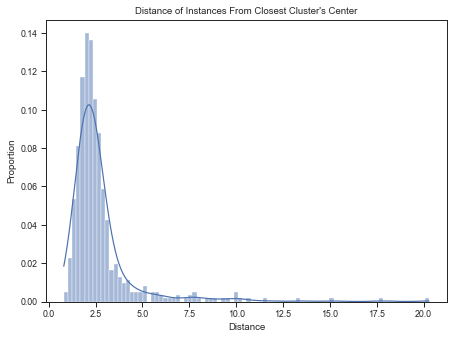

Dataset status after removing outliers:
Number of instances in each cluster (y_pred): {0: 361, 1: 232}
Number of instances in each class (y_true): {0: 536, 1: 22, 2: 20, 3: 15}
Proportion of outliers: 0.0358


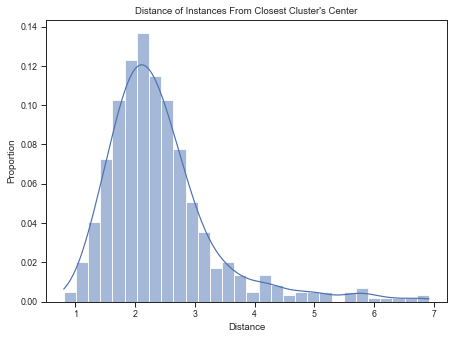

In [4]:
# Part c
np.random.seed(2)

cents = KMeans(X)
y_pred = predict(X, cents)
y_dist = distance_from_center(X, cents)

# Dataset status before removing outliers
print('Dataset status before removing outliers:')
print('Number of instances in each cluster (y_pred):', value_counts(y_pred))
print('Number of instances in each class (y_true):', value_counts(y))
ax = sns.histplot(x=y_dist, kde=True, stat='proportion')
ax.set(title="Distance of Instances From Closest Cluster's Center", xlabel='Distance')
plt.savefig('P2_c1.png')
plt.show()

# Remove outliers
outlier_thr = 7.0
outlier_proportion = np.sum(y_dist >= outlier_thr) / len(y)
X = X[y_dist < outlier_thr]
y = y[y_dist < outlier_thr]
y_pred = y_pred[y_dist < outlier_thr]
y_dist = y_dist[y_dist < outlier_thr]

# Dataset status after removing outliers
print('Dataset status after removing outliers:')
print('Number of instances in each cluster (y_pred):', value_counts(y_pred))
print('Number of instances in each class (y_true):', value_counts(y))
print('Proportion of outliers:', round(outlier_proportion, 4))
ax = sns.histplot(x=y_dist, kde=True, stat='proportion')
ax.set(title="Distance of Instances From Closest Cluster's Center", xlabel='Distance')
plt.savefig('P2_c2.png')
plt.show()


In [5]:
# Part d
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, stratify=y)


In [6]:
# Part e

def purity_score(y_true, y_pred):
    s = 0
    for c in np.unique(y_pred):
        _, lcnt = np.unique(y_true[y_pred == c], return_counts=True)
        s += np.max(lcnt)
    return s / len(y_pred)


def entropy_score(y_true, y_pred):
    s = 0
    for c in np.unique(y_pred):
        _, lcnt = np.unique(y_true[y_pred == c], return_counts=True)
        m_c = np.sum(lcnt)
        E_c = -np.sum([(t/m_c) * np.log2(t/m_c) for t in lcnt])
        m = len(y_pred)
        s += (m_c/m) * E_c
    return s


def confusion_matrix(y_true, y_pred, labels):
    """Customized only for clustering task (Not classification)"""
    m = np.zeros((len(labels), len(labels)), dtype=int)
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            m[i, j] = np.sum((y_true == i) & (y_pred == labels[j]))
    return m


def accuracy_score(y_true, y_pred):
    """Customized only for clustering task (Not classification)"""
    import itertools
    permutations = itertools.permutations(np.unique(y_pred))
    max_score = 0
    for prt in permutations:
        cm = confusion_matrix(y_true, y_pred, prt)
        score = np.sum(np.diag(cm)) / len(y_pred)
        if score > max_score:
            max_score = score
    return max_score


In [7]:
# Part e
cents = KMeans(X_train)
y_pred = predict(X_test, cents)
y_true = y_test.copy()

y_true[y_true == 0] = -1
y_true[y_true > 0] = 0
y_true[y_true == -1] = 1

print('Results for Euclidean:')
print('Purity:', round(purity_score(y_true, y_pred), 4))
print('Entropy:', round(entropy_score(y_true, y_pred), 4))
print('Accuracy:', round(accuracy_score(y_true, y_pred), 4))
print('Centers:')
print(cents, '\n')


cents = KMeans(X_train, DistanceMetric=CityBlock)
y_pred = predict(X_test, cents, DistanceMetric=CityBlock)
y_true = y_test.copy()

y_true[y_true == 0] = -1
y_true[y_true > 0] = 0
y_true[y_true == -1] = 1

print('Results for CityBlock:')
print('Purity:', round(purity_score(y_true, y_pred), 4))
print('Entropy:', round(entropy_score(y_true, y_pred), 4))
print('Accuracy:', round(accuracy_score(y_true, y_pred), 4))
print('Centers:')
print(cents)


Results for Euclidean:
Purity: 0.9076
Entropy: 0.4445
Accuracy: 0.5546
Centers:
[[ 0.0919 -0.923  -0.4066 -0.1159 -0.3178 -0.2336 -0.125  -0.4203 -0.0891
  -0.2203 -0.2782 -0.2939]
 [-0.1091  0.7019  0.4509 -0.0143  0.1852 -0.0198 -0.0503  0.402   0.1467
   0.0614  0.0099  0.2907]] 

Results for CityBlock:
Purity: 0.9076
Entropy: 0.4394
Accuracy: 0.521
Centers:
[[-0.2049  0.6618  0.4981 -0.0261  0.2626  0.0428 -0.029   0.494   0.1584
   0.0696  0.0619  0.4267]
 [ 0.1556 -0.6562 -0.3314 -0.0904 -0.3213 -0.2636 -0.1349 -0.3931 -0.0672
  -0.1886 -0.2875 -0.3421]]


In [8]:
# Part f
cents = KMeans(X_train, ClusterCount=4)
y_pred = predict(X_test, cents)
y_true = y_test.copy()

print('Results for Euclidean:')
print('Purity:', round(purity_score(y_true, y_pred), 4))
print('Entropy:', round(entropy_score(y_true, y_pred), 4))
print('Accuracy:', round(accuracy_score(y_true, y_pred), 4))
print('Centers:')
print(cents, '\n')


cents = KMeans(X_train, ClusterCount=4, DistanceMetric=CityBlock)
y_pred = predict(X_test, cents, DistanceMetric=CityBlock)
y_true = y_test.copy()

print('Results for CityBlock:')
print('Purity:', round(purity_score(y_true, y_pred), 4))
print('Entropy:', round(entropy_score(y_true, y_pred), 4))
print('Accuracy:', round(accuracy_score(y_true, y_pred), 4))
print('Centers:')
print(cents)


Results for Euclidean:
Purity: 0.9076
Entropy: 0.5128
Accuracy: 0.3529
Centers:
[[-4.4094e-02 -1.2586e+00 -7.2146e-02 -1.1434e-01 -3.2487e-01 -3.3597e-01
  -2.2311e-01 -1.9316e-01  1.3054e-01 -2.2433e-01 -3.1323e-01  3.3222e-04]
 [ 2.4205e-01  7.3295e-01  3.0070e-01  2.6591e-01  5.8262e-01  3.9429e-02
  -7.0801e-02  8.1864e-01  8.8700e-01  1.1703e-01  2.7220e-01  4.7958e-01]
 [-4.6167e-01  7.9454e-01  4.7569e-01 -1.9734e-01 -8.5691e-02 -5.7668e-02
  -4.1034e-02  1.7461e-01 -3.6383e-01  2.3536e-02 -1.4836e-01  1.6439e-01]
 [ 8.7309e-01  3.4286e-01 -1.0918e+00 -9.6856e-02 -1.2397e-01  1.7492e-01
   2.4608e-01 -1.1139e+00 -7.0732e-01 -1.2378e-01 -1.2042e-01 -1.1360e+00]] 

Results for CityBlock:
Purity: 0.9244
Entropy: 0.384
Accuracy: 0.3866
Centers:
[[-0.1567  0.7225  0.6246  0.0674  0.2897  0.0329 -0.0359  0.7792  0.7494
   0.1099  0.179   0.5976]
 [-0.2455  0.4322  0.0484 -0.248   2.7481  1.4877  0.0328 -0.3188 -0.6512
  -0.1564  0.7943  0.3351]
 [ 0.0044 -1.2586 -0.1986 -0.0794 -0.340